In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import warnings
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings('ignore')

## K-Means Clustering 
1. Choose the number of clusters(K) and obtain the data points 
2. Place the centroids c_1, c_2, ..... c_k randomly 
3. Repeat steps 4 and 5 until convergence or until the end of a fixed number of iterations
4. for each data point x_i:
       - find the nearest centroid(c_1, c_2 .. c_k) 
       - assign the point to that cluster 
5. for each cluster j = 1..k
       - new centroid = mean of all points assigned to that cluster
6. End 

In [2]:
class KMeans:
    
    def __init__(self, n_clusters, n_iter=1000, n_init=10, limit=1e-6):
        self.n_clusters = n_clusters
        self.n_iter = n_iter
        self.limit = limit
        self.n_init = n_init
        self.cluster_centers_ = None
        self.error = None
        self.labels = None

    def _reinit(self, path):
        with open(path, 'rb') as f:
            curr_best = pickle.load(f)

        for k in curr_best.__dict__.keys():
            setattr(self, k, getattr(curr_best, k))
    
    def _save(self, path):
        with open(path, 'wb') as f:
            pickle.dump(self, f)
    
    def _load(self, path):
        with open(path, 'rb') as f:
            return pickle.load(f)

    def init_centers(self, X):
        shuffe_data = np.random.permutation(X)
        return shuffe_data[:self.n_clusters]
        
    def compute_dist(self, X):
        dist = np.zeros((X.shape[0], self.n_clusters))
        for k, center in enumerate(self.cluster_centers_):
            dist[:,k] = np.linalg.norm(X - center, 2, axis=1)
        return dist

    def assign(self, dist_matrix):
        return np.argmin(dist_matrix, axis=1)
    
    def centroids(self, X, labels):
        _centers = np.zeros((self.n_clusters, X.shape[1]))
        for k in range(self.n_clusters):
            _centers[k, :] = np.mean(X[labels == k, :], axis=0)
        return _centers
    
    def get_error(self, X, labels, centers):
        _dist = np.zeros(X.shape[0])
        for k in range(self.n_clusters):
            _dist[labels == k] = np.linalg.norm(X[labels == k] - centers[k], axis=1)
        return np.sum(np.square(_dist))
    
    def _train(self, X, centroids=None):
        self.cluster_centers_ = self.init_centers(X) if centroids is None else centroids
        for _iter in range(self.n_iter):
            old_centers = self.cluster_centers_
            dist = self.compute_dist(X)
            labels = self.assign(dist)
            self.cluster_centers_ = self.centroids(X, labels)
            self.error = self.get_error(X, labels, self.cluster_centers_)
    
            if (np.all(old_centers == self.cluster_centers_) or self.error < self.limit):
                break
   
    def fit(self, X, path='./saved_model.pickle', centroids=None, verbose=False):
        curr_best = -1
    
        for _ in range(self.n_init):
            self._train(X, centroids)
            if verbose:
                print ("{:3}/{} :: Error - {}".format(_, self.n_init, self.error))
            
            if curr_best == -1 or self.error < curr_best:
                curr_best = self.error
                self._save(path)
        
        self._reinit(path)
        self.labels = self.predict(X)

    def predict(self, Y):
        _dist = self.compute_dist(Y)
        return self.assign(_dist)

    @classmethod
    def plot_elbow_curve(cls, X, start, end, step):
        """Plots the Curve of distortion vs Number of Clusters against the data.
        Helps you choose an optimal number of clusters"""
        distortions = []
        n_cluster = []
        for i in range (start, end + 1, step):
            n_cluster.append(i)
            temp_obj = KMeans(i)
            temp_obj.fit(X)
            distortions.append(temp_obj.error)

        # plot
        plt.plot(n_cluster, distortions, marker='o')
        plt.xlabel('Number of clusters')
        plt.ylabel('Distortion')
        

In [3]:
data = pd.read_pickle('./state_clubbed_df.pickle')
data

,state,year,murder,rape,foeticide,kidnapping and abduction,abetment of suicide,exposure and abandonment,procuration of minor girls,selling girls for prostitution,prohibition of child marriage act,other crimes,total
0,andhra pradesh,2001,35.0,84.0,0.0,57.0,7.0,22.0,12.0,0.0,6.0,47.0,270.0
1,arunachal pradesh,2001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,assam,2001,0.0,0.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,18.0
3,bihar,2001,2.0,16.0,0.0,26.0,0.0,1.0,16.0,1.0,2.0,18.0,83.0
4,chhattisgarh,2001,14.0,150.0,5.0,46.0,1.0,15.0,0.0,0.0,0.0,354.0,585.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,d&n haveli,2015,2.0,2.0,0.0,14.0,0.0,2.0,0.0,0.0,0.0,2.0,35.0
523,daman & diu,2015,1.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0
524,delhi,2015,54.0,927.0,3.0,6881.0,0.0,23.0,0.0,6.0,0.0,231.0,9489.0
525,lakshadweep,2015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


In [4]:
all_headers = data.columns
all_headers

Index(['state', 'year', 'murder', 'rape', 'foeticide',
       'kidnapping and abduction', 'abetment of suicide',
       'exposure and abandonment', 'procuration of minor girls',
       'selling girls for prostitution', 'prohibition of child marriage act',
       'other crimes', 'total'],
      dtype='object')

In [5]:
cols_to_norm = all_headers[2:-1]
print (cols_to_norm)

Index(['murder', 'rape', 'foeticide', 'kidnapping and abduction',
       'abetment of suicide', 'exposure and abandonment',
       'procuration of minor girls', 'selling girls for prostitution',
       'prohibition of child marriage act', 'other crimes'],
      dtype='object')


In [6]:
data[cols_to_norm] = StandardScaler().fit_transform(data[cols_to_norm])
data

,state,year,murder,rape,foeticide,kidnapping and abduction,abetment of suicide,exposure and abandonment,procuration of minor girls,selling girls for prostitution,prohibition of child marriage act,other crimes,total
0,andhra pradesh,2001,-0.088951,-0.293383,-0.422895,-0.331227,0.899853,-0.024876,-0.085015,-0.183679,0.287960,-0.288916,270.0
1,arunachal pradesh,2001,-0.518114,-0.556170,-0.422895,-0.391738,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.386870,0.0
2,assam,2001,-0.518114,-0.556170,-0.422895,-0.372629,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.386870,18.0
3,bihar,2001,-0.493590,-0.506115,-0.422895,-0.364137,-0.281905,-0.417052,-0.041155,-0.092531,-0.198824,-0.349356,83.0
4,chhattisgarh,2001,-0.346449,-0.086907,0.247176,-0.342905,-0.113082,-0.155602,-0.216594,-0.183679,-0.442216,0.350914,585.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
522,d&n haveli,2015,-0.493590,-0.549913,-0.422895,-0.376876,-0.281905,-0.398377,-0.216594,-0.183679,-0.442216,-0.382702,35.0
523,daman & diu,2015,-0.505852,-0.556170,-0.422895,-0.369445,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.386870,28.0
524,delhi,2015,0.144024,2.343874,-0.020852,6.913125,-0.281905,-0.006201,-0.216594,0.363206,-0.442216,0.094565,9489.0
525,lakshadweep,2015,-0.518114,-0.556170,-0.422895,-0.391738,-0.281905,-0.435728,-0.216594,-0.183679,-0.442216,-0.384786,2.0


In [7]:
import nbimporter
from pca import PCA

Importing Jupyter notebook from pca.ipynb


In [8]:
n_features = len(cols_to_norm)
n_features

10

([<matplotlib.axis.XTick at 0x7fb512f299d0>,
 <a list of 10 Text major ticklabel objects>)

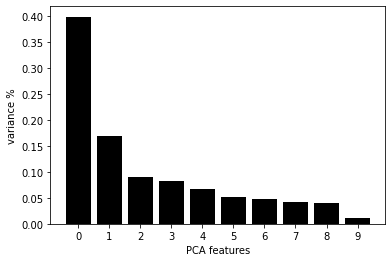

In [9]:
pca = PCA(n_components=n_features)
principal_components = pca.fit_transform(data[cols_to_norm].to_numpy())
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

In [10]:
PCA_components = pd.DataFrame(principal_components)
PCA_components = pd.concat([data[all_headers[:2]], PCA_components.loc[:, [0,1]]], axis=1)
PCA_components

,state,year,0,1
0,andhra pradesh,2001,-0.228578,0.050406
1,arunachal pradesh,2001,-1.230578,-0.237921
2,assam,2001,-1.224106,-0.236560
3,bihar,2001,-1.098062,0.019818
4,chhattisgarh,2001,-0.259834,-0.514825
...,...,...,...,...
522,d&n haveli,2015,-1.199630,-0.241129
523,daman & diu,2015,-1.218726,-0.236485
524,delhi,2015,3.331256,0.160154
525,lakshadweep,2015,-1.229735,-0.238179


<module 'matplotlib.pyplot' from '/home/pranjal/.local/share/virtualenvs/crime-analysis-report-pk3Cf-oK/lib/python3.7/site-packages/matplotlib/pyplot.py'>

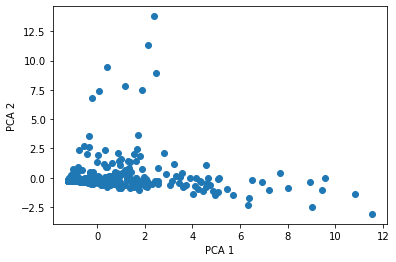

In [11]:
plt.scatter(PCA_components[0], PCA_components[1])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt

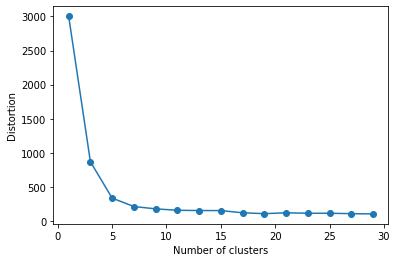

In [12]:
KMeans.plot_elbow_curve(PCA_components.loc[:, [0,1]].to_numpy(), 1, 30, 2)

In [13]:
clusterer = KMeans(n_clusters=5)
clusterer.fit(PCA_components.loc[:, [0,1]].to_numpy())

Text(0.5, 1.0, 'KMeans (K = 5)')

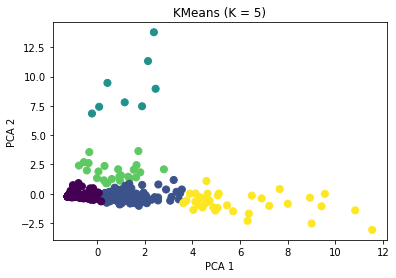

In [14]:
plt.scatter(PCA_components[0], PCA_components[1], c=clusterer.labels, s=50)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.title("KMeans (K = 5)")